# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: 47
* Students: Leo Capiod ; Frank Schmutz ; Harold Sussmilch ; Josef Weber
* Dataset: Flight Routes : airports and routes for ms 1

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

## 0 - Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers

import pygsp
from pygsp import *

For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.

Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).

_Note_: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".  

In [3]:
adjacency = np.load("../data/largest_connected_component_adjacency.npy")

laplacian = np.load("../data/laplacian_combinatorial_cluster.npy")
labels = np.load("../data/cluster_labels.npy")
n_nodes = laplacian.shape[1]

In [411]:
N = adjacency.shape[0]  # number of nodes
E = (int)(np.count_nonzero(adjacency)/2)  # number of edges (non-zero entries of A)
gradient = np.zeros((E, N))
eij = 0  # edge index
for i in range(N):
    for j in range(i, N):
        wij = adjacency[i, j]
        if wij > 0:
            gradient[eij, i] = np.sqrt(wij) * (-1)
            gradient[eij, j] = np.sqrt(wij) * 1
            eij = eij + 1  # increment the edge index

In [419]:
gradient_laplacian = gradient.T.dot(gradient)

In [420]:
np.testing.assert_allclose(gradient_laplacian, laplacian)

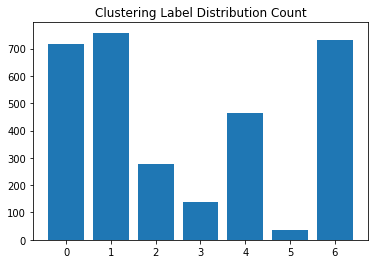

In [4]:
import pandas as pd
df_label_dist = pd.DataFrame({"c":labels})
label_dist = df_label_dist["c"].value_counts()

fig, ax = plt.subplots()
plt.title("Clustering Label Distribution Count")
plt.bar(label_dist.index, label_dist.values)
plt.show()

## 1 - Graph Fourier Transform

In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.

### Question 1

Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.

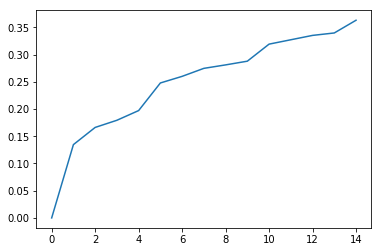

In [5]:

#e Ordered Laplacian eigenvalues.
e, v = np.linalg.eigh(laplacian)
plt.plot(e[0:15])

#U = # Ordered graph Fourier basis. signals == eigenvectors
U = v

G = graphs.Graph(adjacency)
G.set_coordinates(kind='spring', seed=42)


In [12]:
def plot_fourier_q1(G, vec, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    _ = ax.set_title('Noisy signal')
    plt.title("YOYOYO" + title)
    plotting.plot_signal(G, vec, ax=ax, plot_name="Fourier basis vector: " + title)

Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.

#### Vectors 1, 2, 3

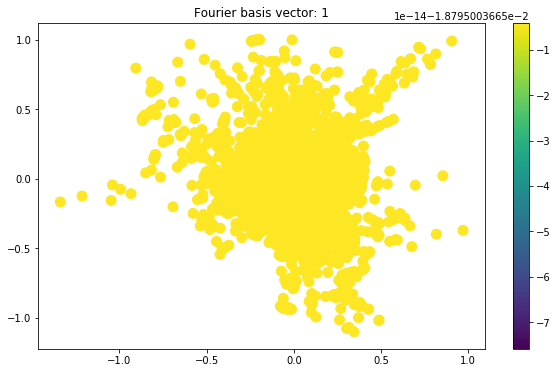

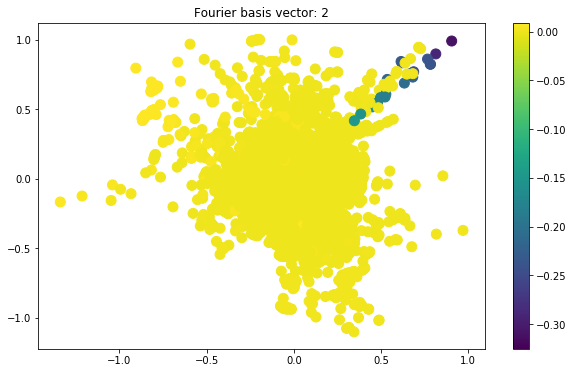

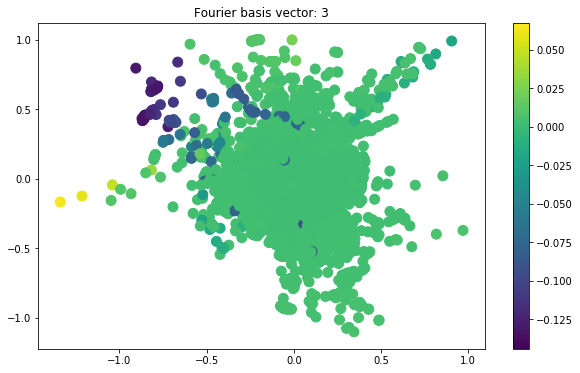

In [13]:
plot_fourier_q1(G, v[:,0], "1")
plot_fourier_q1(G, v[:,1], "2")
plot_fourier_q1(G, v[:,2], "3")

##### Vector n-1

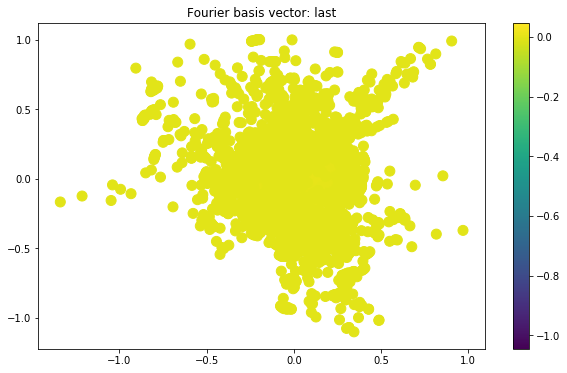

In [14]:
plot_fourier_q1(G, v[:,n_nodes-1], "last")

### Question 2

What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?

Eigenvectors associated with smaller eigenvalues have values that vary less rapidly along the edges.
In terms of graph frequencies, this can be justified by the fact that eigenvectors corresponding to smaller eigenvalues are associated with low frequency whereas eigenvectors corresponding to higher eigenvalues are associated with high frequency signals.
From $L = U^\top \Lambda U$, we have $U_0^\top L U_0=\lambda_0$ corresponding to the lower frequency and $U_{N-1}^\top L U_{N-1}=\lambda_{max}$ corresponding to the higher frequency.
Another possible interpretation of eigenvalues as graph frequencies would be to plot the number of zero crossings as a function of the eigenvalues. We would see that the number of zero crosses increases when the eigenvalue $\lambda$ increases.

### Question 3

Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).

In [15]:
def GFT(x):
    return U.T.dot(x)

def iGFT(x):
    return U.dot(x)

### Question 4

Plot your feature/label vector as a signal on your graph

Text(0.5,1,'graph signal')

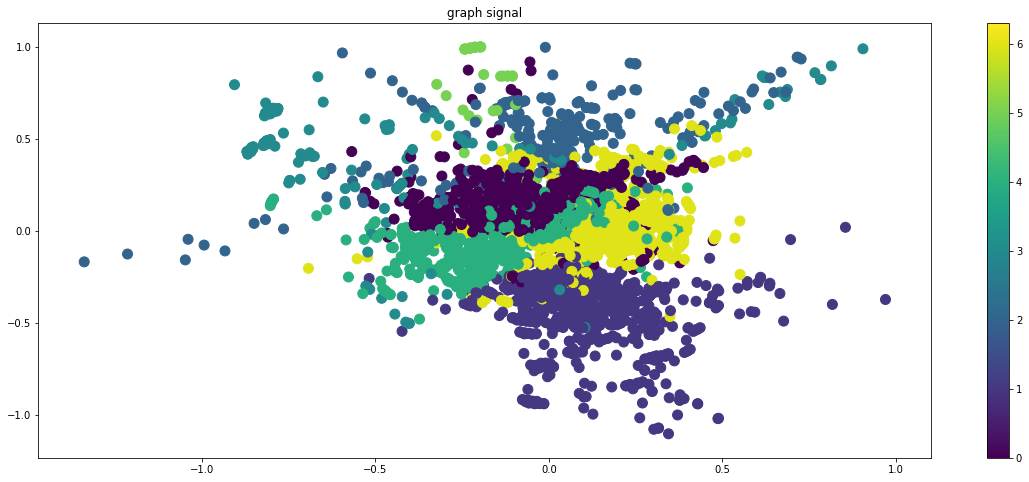

In [16]:
G.plot_signal(labels)
figure = plt.gcf()
figure.set_size_inches((20,8))
plt.title("graph signal")
#in our case the signal is the label associated to each airport 

Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.

Text(0.5,0,'Eigenvalues')

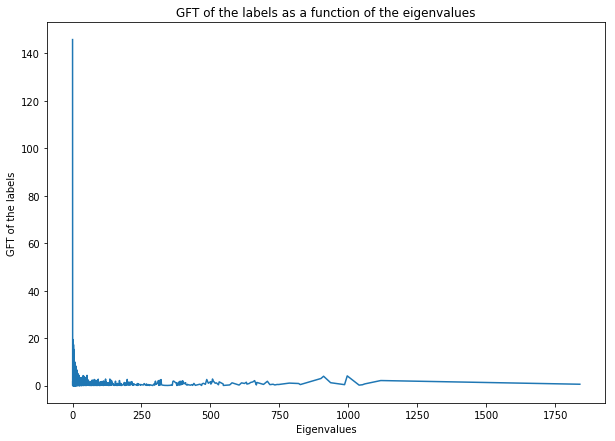

In [17]:
GFT_labels = abs(GFT(labels))
figure = plt.figure(figsize=(10,7))
plt.plot(e, GFT_labels)
plt.title("GFT of the labels as a function of the eigenvalues")
plt.ylabel("GFT of the labels")
plt.xlabel("Eigenvalues")

### Question 5

Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?

The GFT shows that our labels can be considered as a low pass signal. Small eigenvalues tend to have higher absolute values of GFT of the label signal. Knowing that lower eigenvalues correspond to low frequencies (small variations of the signal among nodes), 

## 2 - Filtering on graphs

In this section we will check how filtered Dirac impulses diffuse on your graph.

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [18]:
def heat_kernel(e, t):
    return np.exp(e*(-t))

def inverse_kernel(e, t):
    return 1/(1+t*e)

def rectangle_kernel(e, l_min, l_max):
    return ((np.array(e)>l_min) & (np.array(e)<l_max)).astype(int)

def graph_filter(x, kernel, **kwargs):
    foo=kernel(**kwargs)
    return iGFT(np.multiply(foo, GFT(x)))

### Question 7

Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).

Text(0.5,0,'Eigenvalues')

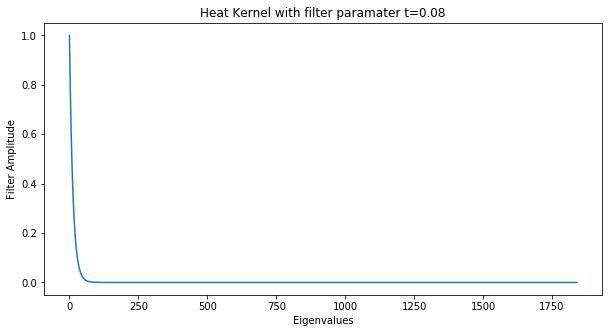

In [222]:
figure = plt.figure(figsize=(10,5))
plt.plot(e, heat_kernel(e,0.08))
plt.title("Heat Kernel with filter paramater t=0.08")
plt.ylabel("Filter Amplitude")
plt.xlabel("Eigenvalues")


Text(0.5,0,'Eigenvalues')

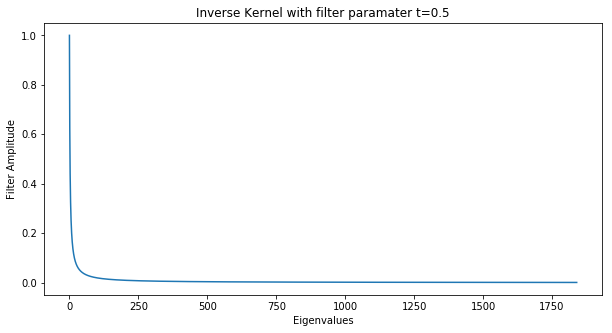

In [221]:
figure = plt.figure(figsize=(10,5))
plt.plot(e, inverse_kernel(e,0.5))
plt.title("Inverse Kernel with filter paramater t=0.5")
plt.ylabel("Filter Amplitude")
plt.xlabel("Eigenvalues")

Text(0.5,0,'Eigenvalues')

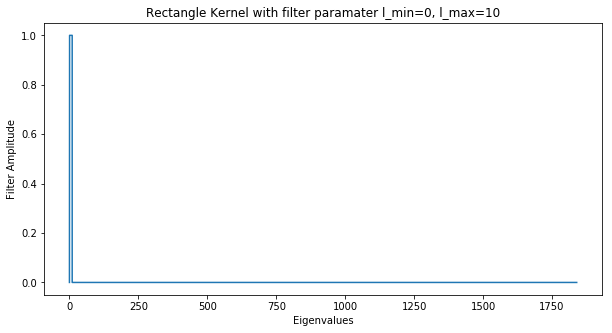

In [21]:
figure = plt.figure(figsize=(10,5))
y=rectangle_kernel(e,0,10)
plt.plot(e, y)
plt.title("Rectangle Kernel with filter paramater l_min=0, l_max=10")
plt.ylabel("Filter Amplitude")
plt.xlabel("Eigenvalues")




### Question 8

Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.

In [198]:
dirac = np.zeros(e.size)

#we can choose arbitrarily 2 dirac impulses by associating high values (as infinite values would not allow us to visualize the diffusion) to 2 random nodes
dirac[12] = 100000
dirac[3000] = 100000



#filtered heat kernel
dirac_heat = graph_filter(dirac, heat_kernel, e=e, t=0.08)

#filtered inverse kernel 
dirac_inverse = graph_filter(dirac, inverse_kernel,e=e, t=0.5)

#filtered rectangle kernel
dirac_rectangle = graph_filter(dirac, rectangle_kernel,e=e, l_min=0, l_max=10)



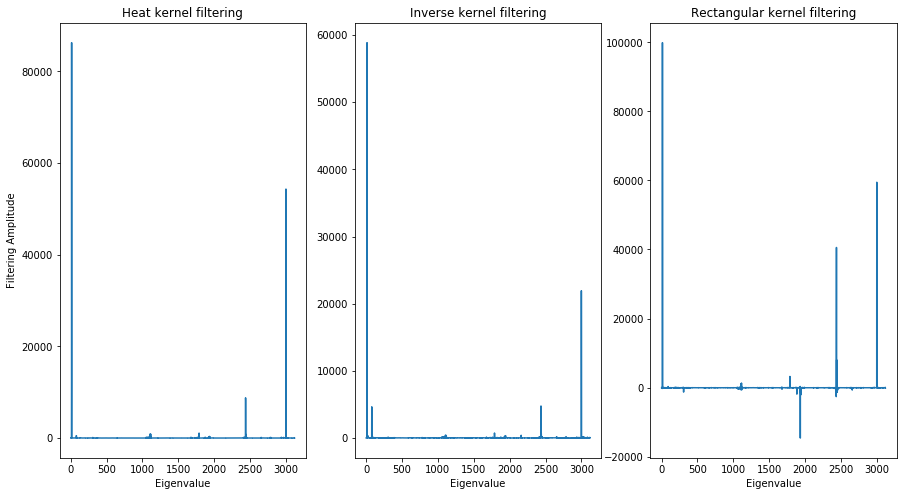

In [199]:
figure = plt.figure(figsize=(15,8))
dirac_plots  = figure.subplots(1,3)
dirac_plots[0].plot(dirac_heat) #filtered heat kernel
dirac_plots[0].set_title('Heat kernel filtering')
dirac_plots[1].plot(dirac_inverse) #filtered inverse kernel
dirac_plots[1].set_title('Inverse kernel filtering')
dirac_plots[2].plot(dirac_rectangle) # filtered rectangular kernel
dirac_plots[2].set_title('Rectangular kernel filtering')
dirac_plots[0].set_ylabel('Filtering Amplitude')
for i in range(3):
    dirac_plots[i].set_xlabel('Eigenvalue')
    

Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.

**Af first glance there seems to be approximately 7 spikes in all 3 graphs, which is the same as our number of connected components. The largest of those spikes are precisely where we inserted them, which was to be expected. The remaining ones represent hubs in other connected components the communication passes through when traveling accross the network.**

## 3 - De-noising

In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.

### Question 9

In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.

_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.

In [346]:
noise_variance = np.var(labels)/1.5
noisy_measurements = labels + np.sqrt(noise_variance) * np.random.randn(n_nodes)

### Question 10

In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.

Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?

To obtain the minimum, we can derive the above expression, the minimum is obtained when the derivative is equal to 0, which gives : $(z^{\star} - y) + \gamma L z^{\star} = 0$ for the solution.

Thus, we can express $z^{\star}$ as a function of  𝑦 ,  𝛾  and  𝐿 : $z^{\star} =(I + \gamma L)^{-1} y $ in which $I$ is the squared identity matrix of dimension $n_{node}^2$

It corresponds to the inverse filtering operation of Q6 applied to the vector $y$, which is also a low pass filtering in the graph spectral domain

### Question 11

Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).

Text(0.5,0,'Eigenvalues')

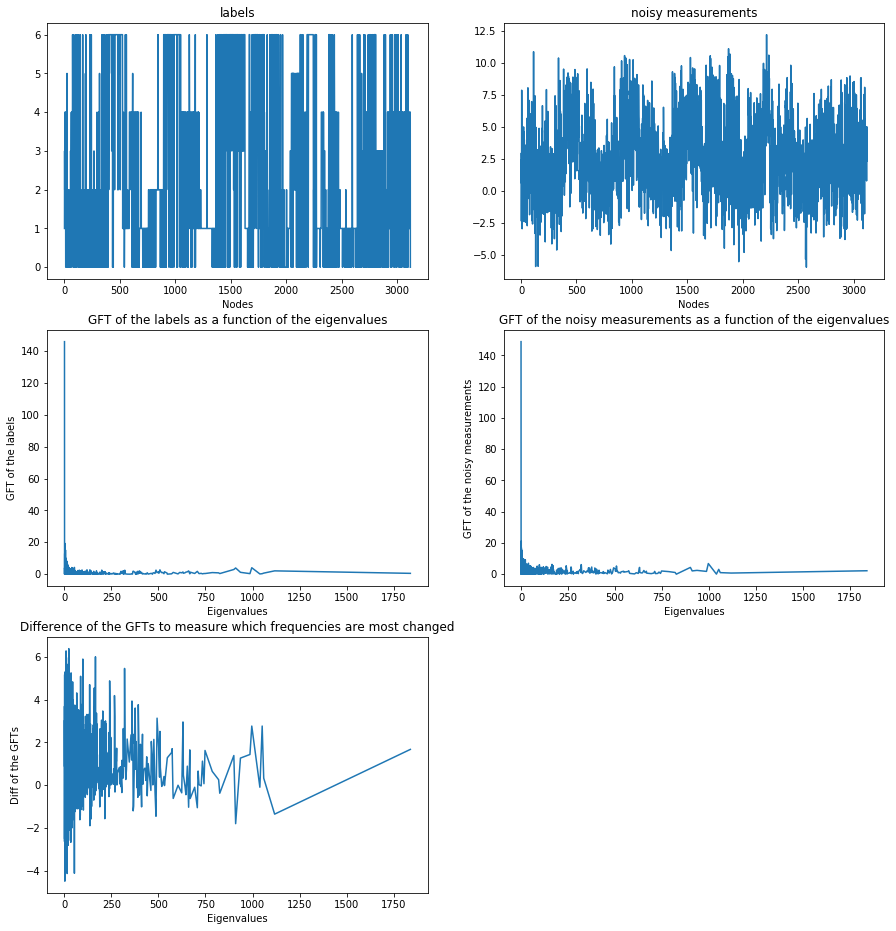

In [347]:
figure = plt.figure(figsize=(15,16))
plt.subplot(321)
plt.plot(labels)
plt.title("labels")
plt.xlabel("Nodes")
plt.subplot(322)
plt.plot(noisy_measurements)
plt.title("noisy measurements")
plt.xlabel("Nodes")
GFT_labels = abs(GFT(labels))
plt.subplot(323)
plt.plot(e, GFT_labels)
plt.title("GFT of the labels as a function of the eigenvalues")
plt.ylabel("GFT of the labels")
plt.xlabel("Eigenvalues")
plt.subplot(324)
GFT_noisy = abs(GFT(noisy_measurements))
plt.plot(e, GFT_noisy)
plt.title("GFT of the noisy measurements as a function of the eigenvalues")
plt.ylabel("GFT of the noisy measurements")
plt.xlabel("Eigenvalues")
plt.subplot(325)
GFT_diff = GFT_noisy - GFT_labels
plt.plot(e, GFT_diff)
plt.title("Difference of the GFTs to measure which frequencies are most changed")
plt.ylabel("Diff of the GFTs")
plt.xlabel("Eigenvalues")

**We can see that the noise increases the low frequencies the most. Therefore it will be very hard to remove it since our labels are mostly in the low frequency end of the spectrum. Still we can see that the very low frequencies (correponding to the first few eigenvalues) are not affected as much as the rest. We can therefore try a low pass filter with a very low frequency cutoff (We do not select a high rate of attenuation because we still want to keep some of those low frequencies).**

In [374]:
z_heat_denoised = np.round(graph_filter(noisy_measurements, heat_kernel, e=e, t=0.12))
z_inv_denoised = np.round(graph_filter(noisy_measurements, inverse_kernel,e=e, t=0.12))
z_rect_denoised = np.round(graph_filter(noisy_measurements, rectangle_kernel,e=e, l_min=0, l_max=e[250]))

Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error 
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
where $z$ is the plotted signal.

Text(0.5,0,'Nodes')

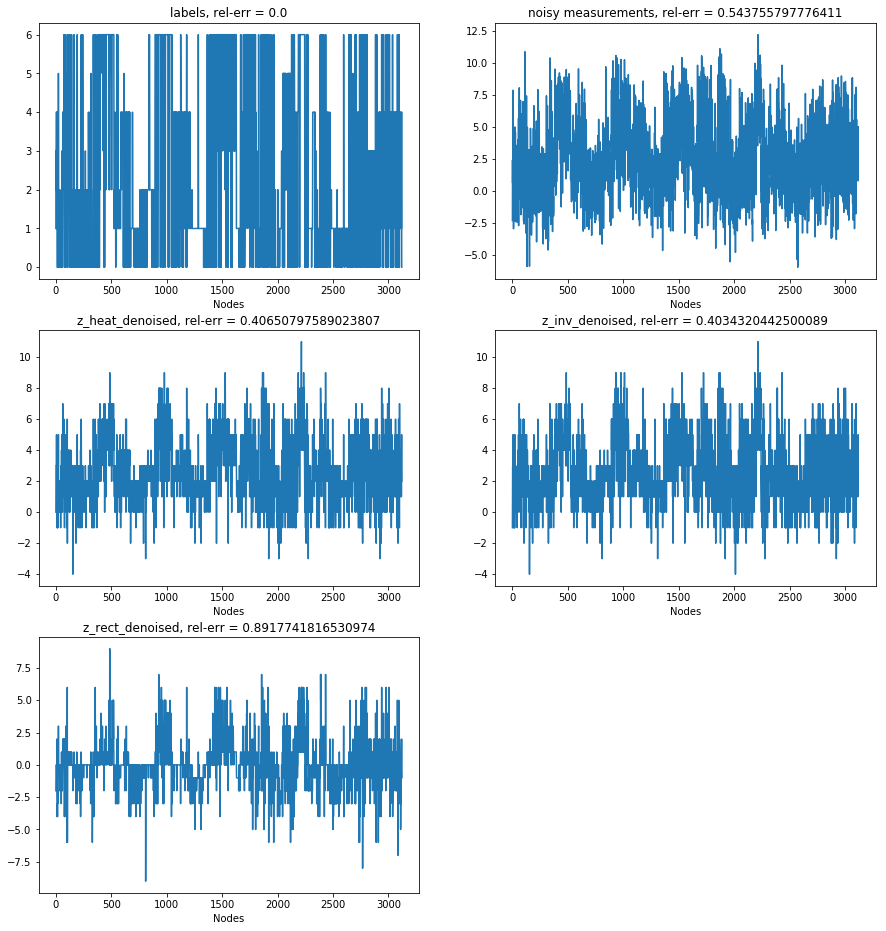

In [375]:
figure = plt.figure(figsize=(15,16))
plt.subplot(321)
labels_rel_err = np.linalg.norm(labels - labels) / np.linalg.norm(labels)
plt.plot(labels)
plt.title("labels, rel-err = " + str(labels_rel_err))
plt.xlabel("Nodes")
plt.subplot(322)
noisy_rel_err = np.linalg.norm(labels - noisy_measurements) / np.linalg.norm(labels)
plt.plot(noisy_measurements)
plt.title("noisy measurements, rel-err = " + str(noisy_rel_err))
plt.xlabel("Nodes")
plt.subplot(323)
heat_rel_err = np.linalg.norm(labels - z_heat_denoised) / np.linalg.norm(labels)
plt.plot(z_heat_denoised)
plt.title("z_heat_denoised, rel-err = " + str(heat_rel_err))
plt.xlabel("Nodes")
plt.subplot(324)
inv_rel_err = np.linalg.norm(labels - z_inv_denoised) / np.linalg.norm(labels)
plt.plot(z_inv_denoised)
plt.title("z_inv_denoised, rel-err = " + str(inv_rel_err))
plt.xlabel("Nodes")
plt.subplot(325)
rect_rel_err = np.linalg.norm(labels - z_rect_denoised) / np.linalg.norm(labels)
plt.plot(z_rect_denoised)
plt.title("z_rect_denoised, rel-err = " + str(rect_rel_err))
plt.xlabel("Nodes")

Finally, overlay on the same plot the GFT of all five signals above.

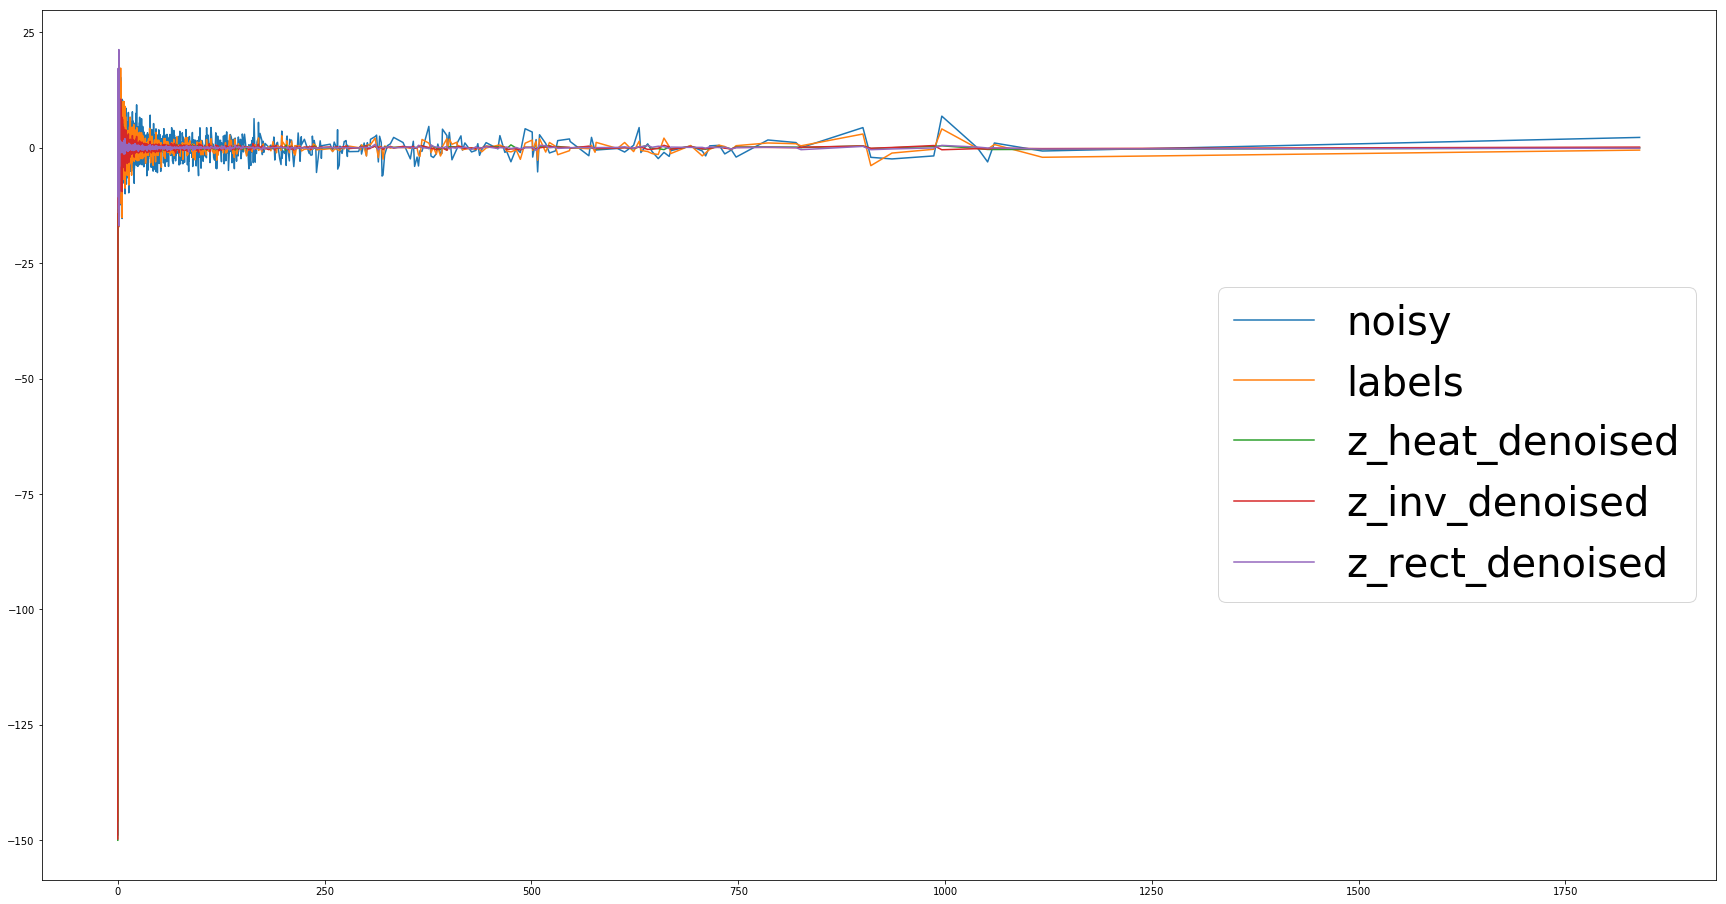

In [376]:
figure = plt.figure(figsize=(30,16))

GFT_labels = GFT(labels)
GFT_noisy = GFT(noisy_measurements)
GFT_heat = GFT(z_heat_denoised)
GFT_inv = GFT(z_inv_denoised)
GFT_rect = GFT(z_rect_denoised)

plt.plot(e, GFT_noisy, label='noisy')
plt.plot(e, GFT_labels, label='labels')
plt.plot(e, GFT_heat, label='z_heat_denoised')
plt.plot(e, GFT_inv, label='z_inv_denoised')
plt.plot(e, GFT_rect, label='z_rect_denoised')

plt.legend(loc='right', prop={'size': 40})

**It's very to see anything in the above plot. Let's shift each GFT vertically**

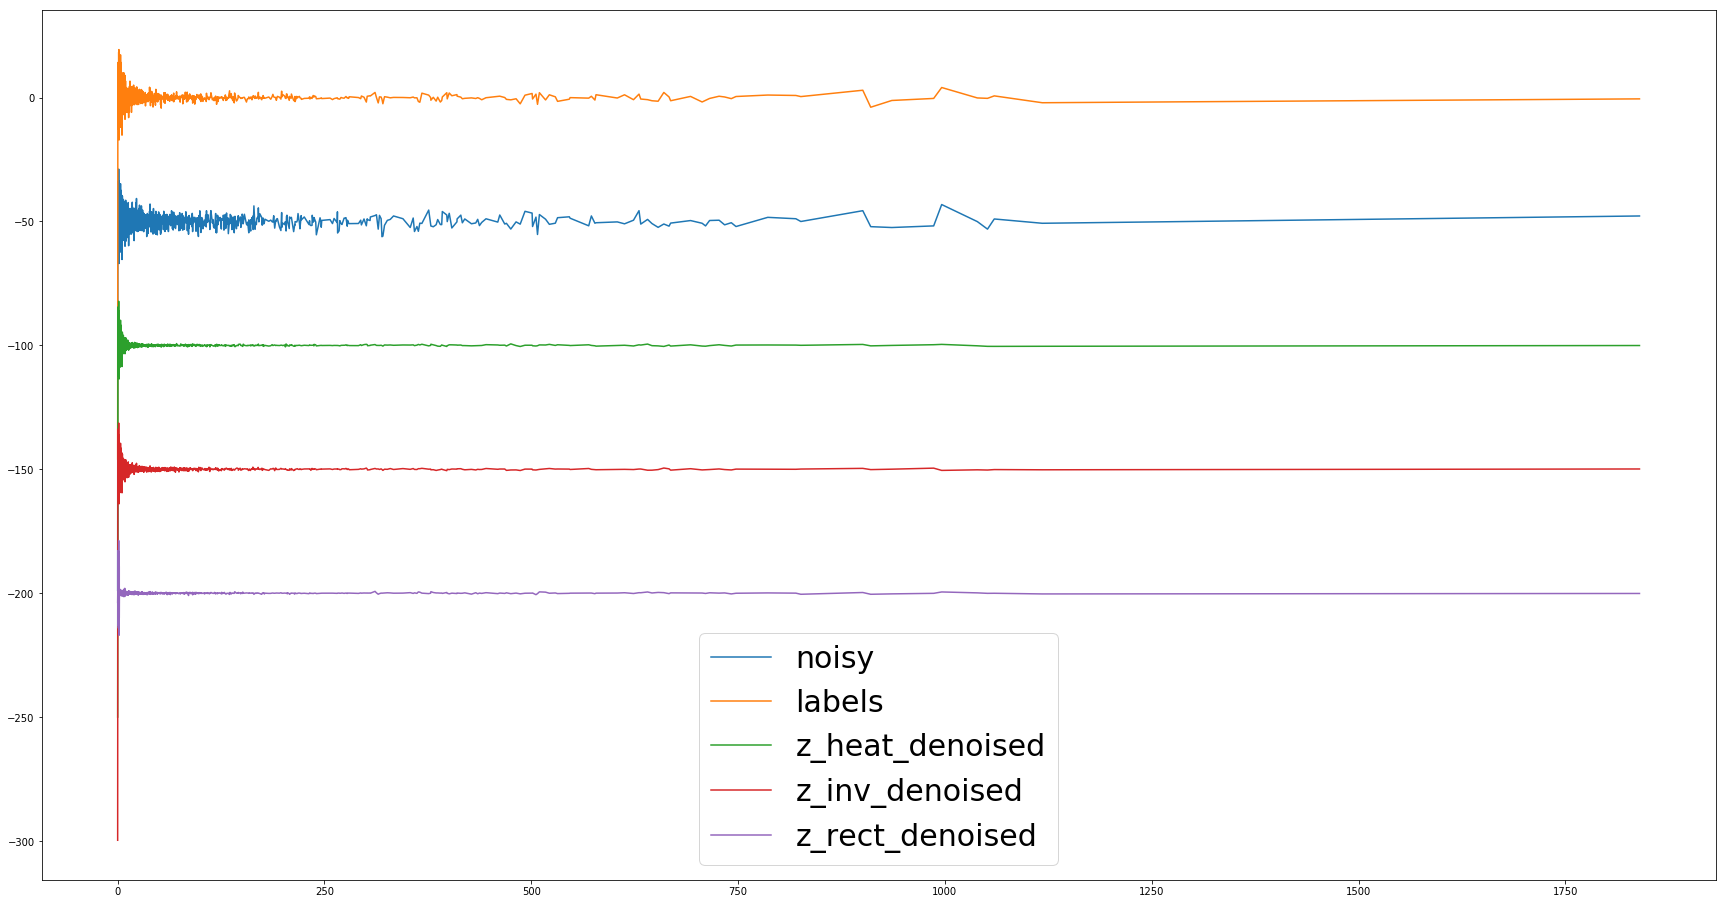

In [377]:
figure = plt.figure(figsize=(30,16))

GFT_labels = GFT(labels)
GFT_noisy = GFT(noisy_measurements) - 50
GFT_heat = GFT(z_heat_denoised) - 100
GFT_inv = GFT(z_inv_denoised) - 150
GFT_rect = GFT(z_rect_denoised) - 200

plt.plot(e, GFT_noisy, label='noisy')
plt.plot(e, GFT_labels, label='labels')
plt.plot(e, GFT_heat, label='z_heat_denoised')
plt.plot(e, GFT_inv, label='z_inv_denoised')
plt.plot(e, GFT_rect, label='z_rect_denoised')

plt.legend(loc='lower center', prop={'size': 30})

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

**The general assumption behind the three filtering approaches is that the GFT of our graph mostly has low frequencies and that the noise is mostlye high frequencies. Therefore a low pass filter should be able to cancel most of the noise. The three techniques simply have different rates at which they attenuate frequencies as well as different cutoff frequencies: the heat method begins to attenuate immediately from the lowest frequency, following an decreasing exponential function. The inverse method is similar but uses an inverse function (of the type 1/x). The rectangle method has a tuneable cutoff frequency but the cutoff is instantaneous. We think the assumption of those methods hold only partially, since the frequencies of the graph and the noise do overlap and we can therefore only use these methods for keeping the lowest frequencies, as seen above. The rectangle method has the worst results since all frequencies above the cutoff frequency (there is a significant amount of those in our graph) are eliminated, while the other two yield a similar result, with a slight edge to the inverse method.**

## 4 - Transductive learning

It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes. 

In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

where $S$ is the set of measured nodes.

In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$

We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".

In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.

### Question 13

Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.

In [275]:
t = (np.max(labels) - np.min(labels)) / 2

In [379]:
labels_bin = np.zeros(labels.shape)
for i in range(len(labels_bin)):
    labels_bin[i] = 1 if labels[i] >= t else -1

Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.

You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.

In [381]:
mn_ratio = 0.3
m = int(mn_ratio * n_nodes)  # Number of measurements.

w = np.random.choice(range(len(labels_bin)), size=m, replace=False)

Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.

In [382]:
subsampled_labels = labels_bin.copy()
subsampled_labels[:] = np.nan
subsampled_labels[w] = labels_bin[w]

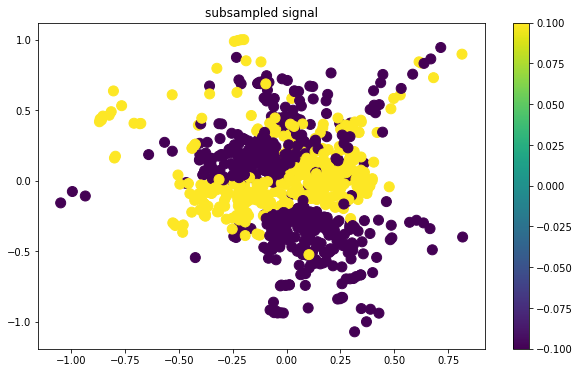

In [449]:
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, subsampled_labels, ax=ax, plot_name="subsampled signal")

### Interlude

For the solution of the variational problems you can use the following function as a "black-box". 

You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).

In [338]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.

_Hint:_ remember you have already computed the mask `w`.

In [390]:
def P(a):
    b = np.zeros(a.shape)
    for i in range(len(a)):
        b[i] = labels_bin[i] if np.any(np.isin(w, i)) else a[i]
    return b

### Question 15

Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.

Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.

In [439]:
sol_1norm_min = graph_pnorm_interpolation(sparse.csr_matrix(gradient), P, x0=np.random.randn(n_nodes), p=1.)

sol_2norm_min = graph_pnorm_interpolation(sparse.csr_matrix(gradient), P, x0=np.random.randn(n_nodes), p=2.)

threshold = 0

sol_1norm_bin = sol_1norm_min.copy()
sol_1norm_bin[np.where(sol_1norm_bin >= threshold)] = 1.0
sol_1norm_bin[np.where(sol_1norm_bin < threshold)] = -1.0

sol_2norm_bin = sol_2norm_min.copy()
sol_2norm_bin[np.where(sol_2norm_bin >= threshold)] = 1.0
sol_2norm_bin[np.where(sol_2norm_bin < threshold)] = -1.0

Solution found after 30 iterations:
    objective function f(sol) = 1.194100e+05
    stopping criterion: RTOL
Solution found after 200 iterations:
    objective function f(sol) = 5.974533e+04
    stopping criterion: MAXIT


Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.

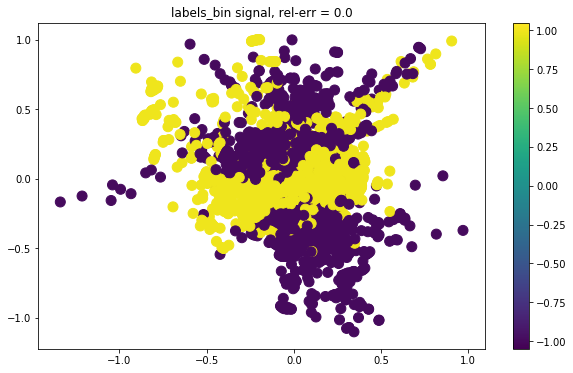

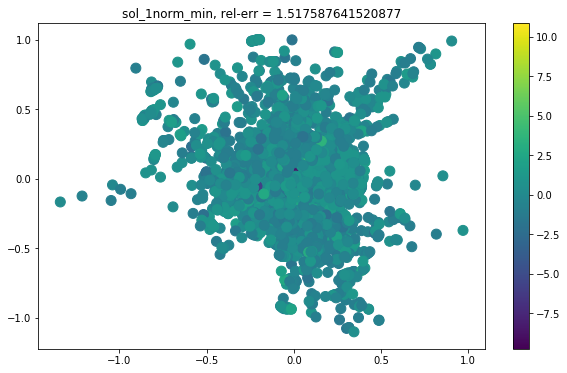

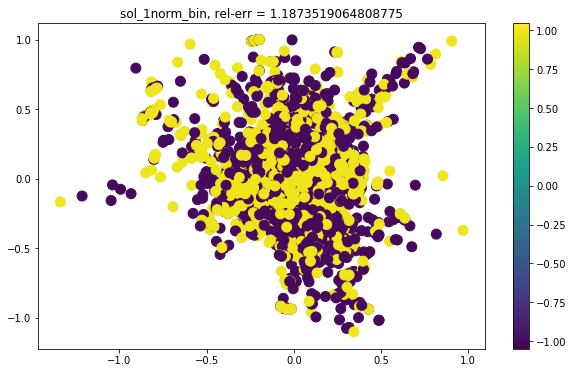

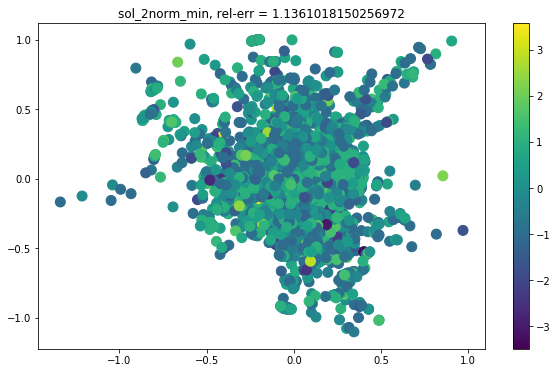

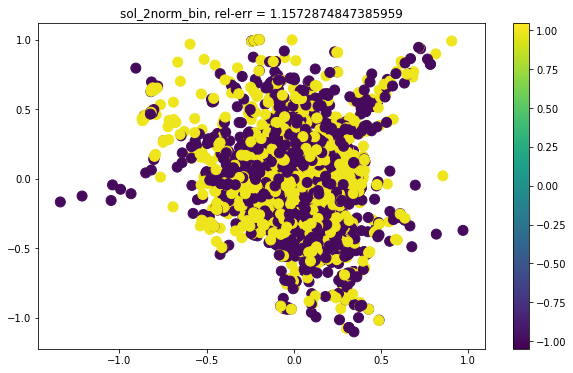

In [454]:
labels_bin_rel_err = np.linalg.norm(labels_bin - labels_bin) / np.linalg.norm(labels_bin)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, labels_bin, ax=ax, plot_name="labels_bin signal, rel-err = " + str(labels_bin_rel_err))

one_norm_min_rel_err = np.linalg.norm(labels_bin - sol_1norm_min) / np.linalg.norm(labels_bin)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, sol_1norm_min, ax=ax, plot_name="sol_1norm_min, rel-err = " + str(one_norm_min_rel_err))

one_norm_bin_rel_err = np.linalg.norm(labels_bin - sol_1norm_bin) / np.linalg.norm(labels_bin)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, sol_1norm_bin, ax=ax, plot_name="sol_1norm_bin, rel-err = " + str(one_norm_bin_rel_err))

two_norm_min_rel_err = np.linalg.norm(labels_bin - sol_2norm_min) / np.linalg.norm(labels_bin)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, sol_2norm_min, ax=ax, plot_name="sol_2norm_min, rel-err = " + str(two_norm_min_rel_err))

two_norm_bin_rel_err = np.linalg.norm(labels_bin - sol_2norm_bin) / np.linalg.norm(labels_bin)
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_signal(G, sol_2norm_bin, ax=ax, plot_name="sol_2norm_bin, rel-err = " + str(two_norm_bin_rel_err))

### Question 16

Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.

Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.

The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.

The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.

In [473]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    
    pt_matrix = np.zeros((len(mn_ratios), len(thresholds)))
    # Create sample mask.
    for i, mn_ratio in enumerate(mn_ratios):
        m = int(mn_ratio * n_nodes)  # Number of measurements.
        
        for j, threshold in enumerate(thresholds):
            agg_rel_err = 0.0
            for k in range(n_trials):
                print('Iteration', k, 'for elem (', i, ',', j, ')')
                # Solve p-norm interpolation.
                w = np.random.choice(range(len(labels_bin)), size=m, replace=False)
                sol = graph_pnorm_interpolation(sparse.csr_matrix(gradient), P, x0=np.random.randn(n_nodes), p=p)
                sol[np.where(sol >= threshold)] = 1.0
                sol[np.where(sol < threshold)] = -1.0
                rel_err = np.linalg.norm(labels_bin - sol) / np.linalg.norm(labels_bin)
                agg_rel_err = agg_rel_err + rel_err
            
            # Aggregate.
            agg_rel_err = agg_rel_err / n_trials
            print('agg_rel_err for elem (', i, ',', j, ') is', agg_rel_err)
            pt_matrix[i,j] = agg_rel_err
    
    return pt_matrix

### Question 17

Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.

In [474]:
mn_ratios = [0.1, 0.2, 0.4, 0.6, 0.8]

thresholds = [-0.8, -0.4, 0, 0.4, 0.8]

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 1)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, 20, labels_bin, 2)

Iteration 0 for elem ( 0 , 0 )
Solution found after 3 iterations:
    objective function f(sol) = 2.796271e+04
    stopping criterion: RTOL
Iteration 1 for elem ( 0 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.153036e+05
    stopping criterion: RTOL
Iteration 2 for elem ( 0 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.155943e+05
    stopping criterion: RTOL
Iteration 3 for elem ( 0 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.112364e+05
    stopping criterion: RTOL
Iteration 4 for elem ( 0 , 0 )
Solution found after 32 iterations:
    objective function f(sol) = 1.101801e+05
    stopping criterion: RTOL
Iteration 5 for elem ( 0 , 0 )
Solution found after 61 iterations:
    objective function f(sol) = 8.445975e+04
    stopping criterion: RTOL
Iteration 6 for elem ( 0 , 0 )
Solution found after 30 iterations:
    objective function f(sol) = 1.192822e+05
    stopping criterion: RTOL
Iteration 7 fo

Solution found after 30 iterations:
    objective function f(sol) = 1.198336e+05
    stopping criterion: RTOL
Iteration 18 for elem ( 0 , 2 )
Solution found after 29 iterations:
    objective function f(sol) = 1.168429e+05
    stopping criterion: RTOL
Iteration 19 for elem ( 0 , 2 )
Solution found after 29 iterations:
    objective function f(sol) = 1.146516e+05
    stopping criterion: RTOL
agg_rel_err for elem ( 0 , 2 ) is 1.17350044603103
Iteration 0 for elem ( 0 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.108277e+05
    stopping criterion: RTOL
Iteration 1 for elem ( 0 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.168156e+05
    stopping criterion: RTOL
Iteration 2 for elem ( 0 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.169362e+05
    stopping criterion: RTOL
Iteration 3 for elem ( 0 , 3 )
Solution found after 31 iterations:
    objective function f(sol) = 1.156849e+05
    stopping criteri

Solution found after 30 iterations:
    objective function f(sol) = 1.119941e+05
    stopping criterion: RTOL
Iteration 15 for elem ( 1 , 0 )
Solution found after 29 iterations:
    objective function f(sol) = 1.152377e+05
    stopping criterion: RTOL
Iteration 16 for elem ( 1 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.129700e+05
    stopping criterion: RTOL
Iteration 17 for elem ( 1 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.133071e+05
    stopping criterion: RTOL
Iteration 18 for elem ( 1 , 0 )
Solution found after 32 iterations:
    objective function f(sol) = 1.107325e+05
    stopping criterion: RTOL
Iteration 19 for elem ( 1 , 0 )
Solution found after 30 iterations:
    objective function f(sol) = 1.163451e+05
    stopping criterion: RTOL
agg_rel_err for elem ( 1 , 0 ) is 1.2072612049782234
Iteration 0 for elem ( 1 , 1 )
Solution found after 30 iterations:
    objective function f(sol) = 1.196243e+05
    stopping cr

Solution found after 31 iterations:
    objective function f(sol) = 1.144704e+05
    stopping criterion: RTOL
Iteration 12 for elem ( 1 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.206222e+05
    stopping criterion: RTOL
Iteration 13 for elem ( 1 , 3 )
Solution found after 31 iterations:
    objective function f(sol) = 1.115226e+05
    stopping criterion: RTOL
Iteration 14 for elem ( 1 , 3 )
Solution found after 3 iterations:
    objective function f(sol) = 2.844572e+04
    stopping criterion: RTOL
Iteration 15 for elem ( 1 , 3 )
Solution found after 61 iterations:
    objective function f(sol) = 8.370133e+04
    stopping criterion: RTOL
Iteration 16 for elem ( 1 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.138966e+05
    stopping criterion: RTOL
Iteration 17 for elem ( 1 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.112498e+05
    stopping criterion: RTOL
Iteration 18 for elem ( 1 , 3 )
Solutio

Solution found after 30 iterations:
    objective function f(sol) = 1.167632e+05
    stopping criterion: RTOL
Iteration 9 for elem ( 2 , 1 )
Solution found after 30 iterations:
    objective function f(sol) = 1.068887e+05
    stopping criterion: RTOL
Iteration 10 for elem ( 2 , 1 )
Solution found after 31 iterations:
    objective function f(sol) = 1.152794e+05
    stopping criterion: RTOL
Iteration 11 for elem ( 2 , 1 )
Solution found after 29 iterations:
    objective function f(sol) = 1.189752e+05
    stopping criterion: RTOL
Iteration 12 for elem ( 2 , 1 )
Solution found after 30 iterations:
    objective function f(sol) = 1.208821e+05
    stopping criterion: RTOL
Iteration 13 for elem ( 2 , 1 )
Solution found after 30 iterations:
    objective function f(sol) = 1.181728e+05
    stopping criterion: RTOL
Iteration 14 for elem ( 2 , 1 )
Solution found after 30 iterations:
    objective function f(sol) = 1.169389e+05
    stopping criterion: RTOL
Iteration 15 for elem ( 2 , 1 )
Solutio

Solution found after 29 iterations:
    objective function f(sol) = 1.144740e+05
    stopping criterion: RTOL
Iteration 6 for elem ( 2 , 4 )
Solution found after 30 iterations:
    objective function f(sol) = 1.132898e+05
    stopping criterion: RTOL
Iteration 7 for elem ( 2 , 4 )
Solution found after 32 iterations:
    objective function f(sol) = 1.123717e+05
    stopping criterion: RTOL
Iteration 8 for elem ( 2 , 4 )
Solution found after 3 iterations:
    objective function f(sol) = 2.869184e+04
    stopping criterion: RTOL
Iteration 9 for elem ( 2 , 4 )
Solution found after 30 iterations:
    objective function f(sol) = 1.124542e+05
    stopping criterion: RTOL
Iteration 10 for elem ( 2 , 4 )
Solution found after 29 iterations:
    objective function f(sol) = 1.198898e+05
    stopping criterion: RTOL
Iteration 11 for elem ( 2 , 4 )
Solution found after 29 iterations:
    objective function f(sol) = 1.179545e+05
    stopping criterion: RTOL
Iteration 12 for elem ( 2 , 4 )
Solution fo

Solution found after 30 iterations:
    objective function f(sol) = 1.131730e+05
    stopping criterion: RTOL
Iteration 3 for elem ( 3 , 2 )
Solution found after 31 iterations:
    objective function f(sol) = 1.095922e+05
    stopping criterion: RTOL
Iteration 4 for elem ( 3 , 2 )
Solution found after 30 iterations:
    objective function f(sol) = 1.089650e+05
    stopping criterion: RTOL
Iteration 5 for elem ( 3 , 2 )
Solution found after 30 iterations:
    objective function f(sol) = 1.153913e+05
    stopping criterion: RTOL
Iteration 6 for elem ( 3 , 2 )
Solution found after 31 iterations:
    objective function f(sol) = 1.086798e+05
    stopping criterion: RTOL
Iteration 7 for elem ( 3 , 2 )
Solution found after 32 iterations:
    objective function f(sol) = 1.139855e+05
    stopping criterion: RTOL
Iteration 8 for elem ( 3 , 2 )
Solution found after 31 iterations:
    objective function f(sol) = 1.139923e+05
    stopping criterion: RTOL
Iteration 9 for elem ( 3 , 2 )
Solution foun

Solution found after 30 iterations:
    objective function f(sol) = 1.103568e+05
    stopping criterion: RTOL
Iteration 1 for elem ( 4 , 0 )
Solution found after 30 iterations:
    objective function f(sol) = 1.118299e+05
    stopping criterion: RTOL
Iteration 2 for elem ( 4 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.125348e+05
    stopping criterion: RTOL
Iteration 3 for elem ( 4 , 0 )
Solution found after 30 iterations:
    objective function f(sol) = 1.164644e+05
    stopping criterion: RTOL
Iteration 4 for elem ( 4 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.075881e+05
    stopping criterion: RTOL
Iteration 5 for elem ( 4 , 0 )
Solution found after 30 iterations:
    objective function f(sol) = 1.178215e+05
    stopping criterion: RTOL
Iteration 6 for elem ( 4 , 0 )
Solution found after 31 iterations:
    objective function f(sol) = 1.092245e+05
    stopping criterion: RTOL
Iteration 7 for elem ( 4 , 0 )
Solution foun

Solution found after 31 iterations:
    objective function f(sol) = 1.155045e+05
    stopping criterion: RTOL
Iteration 19 for elem ( 4 , 2 )
Solution found after 3 iterations:
    objective function f(sol) = 2.798372e+04
    stopping criterion: RTOL
agg_rel_err for elem ( 4 , 2 ) is 1.174962097926974
Iteration 0 for elem ( 4 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.128633e+05
    stopping criterion: RTOL
Iteration 1 for elem ( 4 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.143646e+05
    stopping criterion: RTOL
Iteration 2 for elem ( 4 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.133819e+05
    stopping criterion: RTOL
Iteration 3 for elem ( 4 , 3 )
Solution found after 30 iterations:
    objective function f(sol) = 1.161953e+05
    stopping criterion: RTOL
Iteration 4 for elem ( 4 , 3 )
Solution found after 31 iterations:
    objective function f(sol) = 1.101521e+05
    stopping criterio

Solution found after 200 iterations:
    objective function f(sol) = 5.863229e+04
    stopping criterion: MAXIT
Iteration 16 for elem ( 0 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.051269e+04
    stopping criterion: MAXIT
Iteration 17 for elem ( 0 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.076314e+04
    stopping criterion: MAXIT
Iteration 18 for elem ( 0 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.137363e+04
    stopping criterion: MAXIT
Iteration 19 for elem ( 0 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.412833e+04
    stopping criterion: MAXIT
agg_rel_err for elem ( 0 , 0 ) is 1.2209736652220917
Iteration 0 for elem ( 0 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.191148e+04
    stopping criterion: MAXIT
Iteration 1 for elem ( 0 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.076818e+04
   

Solution found after 200 iterations:
    objective function f(sol) = 6.141070e+04
    stopping criterion: MAXIT
Iteration 13 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.108340e+04
    stopping criterion: MAXIT
Iteration 14 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.626503e+04
    stopping criterion: MAXIT
Iteration 15 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.238475e+04
    stopping criterion: MAXIT
Iteration 16 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.616937e+04
    stopping criterion: MAXIT
Iteration 17 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.044638e+04
    stopping criterion: MAXIT
Iteration 18 for elem ( 0 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.324999e+04
    stopping criterion: MAXIT
Iteration 19 for elem ( 

Solution found after 200 iterations:
    objective function f(sol) = 6.417016e+04
    stopping criterion: MAXIT
Iteration 9 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.436761e+04
    stopping criterion: MAXIT
Iteration 10 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.368751e+04
    stopping criterion: MAXIT
Iteration 11 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.153920e+04
    stopping criterion: MAXIT
Iteration 12 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.058498e+04
    stopping criterion: MAXIT
Iteration 13 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.477638e+04
    stopping criterion: MAXIT
Iteration 14 for elem ( 1 , 1 )
Solution found after 200 iterations:
    objective function f(sol) = 6.065383e+04
    stopping criterion: MAXIT
Iteration 15 for elem ( 1

Solution found after 200 iterations:
    objective function f(sol) = 6.205556e+04
    stopping criterion: MAXIT
Iteration 5 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.567629e+04
    stopping criterion: MAXIT
Iteration 6 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.111988e+04
    stopping criterion: MAXIT
Iteration 7 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.244367e+04
    stopping criterion: MAXIT
Iteration 8 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.196133e+04
    stopping criterion: MAXIT
Iteration 9 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.371082e+04
    stopping criterion: MAXIT
Iteration 10 for elem ( 1 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.099923e+04
    stopping criterion: MAXIT
Iteration 11 for elem ( 1 , 4

Solution found after 200 iterations:
    objective function f(sol) = 5.967060e+04
    stopping criterion: MAXIT
Iteration 1 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.305689e+04
    stopping criterion: MAXIT
Iteration 2 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.556649e+04
    stopping criterion: MAXIT
Iteration 3 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.006115e+04
    stopping criterion: MAXIT
Iteration 4 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.318606e+04
    stopping criterion: MAXIT
Iteration 5 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.137636e+04
    stopping criterion: MAXIT
Iteration 6 for elem ( 2 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.330440e+04
    stopping criterion: MAXIT
Iteration 7 for elem ( 2 , 2 )

Solution found after 200 iterations:
    objective function f(sol) = 6.307549e+04
    stopping criterion: MAXIT
Iteration 18 for elem ( 2 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.442261e+04
    stopping criterion: MAXIT
Iteration 19 for elem ( 2 , 4 )
Solution found after 200 iterations:
    objective function f(sol) = 6.363431e+04
    stopping criterion: MAXIT
agg_rel_err for elem ( 2 , 4 ) is 1.142472013879082
Iteration 0 for elem ( 3 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.120995e+04
    stopping criterion: MAXIT
Iteration 1 for elem ( 3 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.212473e+04
    stopping criterion: MAXIT
Iteration 2 for elem ( 3 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.253454e+04
    stopping criterion: MAXIT
Iteration 3 for elem ( 3 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.047294e+04
    st

Solution found after 200 iterations:
    objective function f(sol) = 6.547661e+04
    stopping criterion: MAXIT
Iteration 15 for elem ( 3 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.485769e+04
    stopping criterion: MAXIT
Iteration 16 for elem ( 3 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.047583e+04
    stopping criterion: MAXIT
Iteration 17 for elem ( 3 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.204380e+04
    stopping criterion: MAXIT
Iteration 18 for elem ( 3 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 6.141432e+04
    stopping criterion: MAXIT
Iteration 19 for elem ( 3 , 2 )
Solution found after 200 iterations:
    objective function f(sol) = 5.986655e+04
    stopping criterion: MAXIT
agg_rel_err for elem ( 3 , 2 ) is 1.1661539496402014
Iteration 0 for elem ( 3 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.117957e+04
  

Solution found after 200 iterations:
    objective function f(sol) = 6.170314e+04
    stopping criterion: MAXIT
Iteration 12 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.036176e+04
    stopping criterion: MAXIT
Iteration 13 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.353131e+04
    stopping criterion: MAXIT
Iteration 14 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.336516e+04
    stopping criterion: MAXIT
Iteration 15 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.087058e+04
    stopping criterion: MAXIT
Iteration 16 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.439127e+04
    stopping criterion: MAXIT
Iteration 17 for elem ( 4 , 0 )
Solution found after 200 iterations:
    objective function f(sol) = 6.167471e+04
    stopping criterion: MAXIT
Iteration 18 for elem ( 

Solution found after 200 iterations:
    objective function f(sol) = 6.050767e+04
    stopping criterion: MAXIT
Iteration 8 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.191624e+04
    stopping criterion: MAXIT
Iteration 9 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 5.999442e+04
    stopping criterion: MAXIT
Iteration 10 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.408913e+04
    stopping criterion: MAXIT
Iteration 11 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.449853e+04
    stopping criterion: MAXIT
Iteration 12 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.441622e+04
    stopping criterion: MAXIT
Iteration 13 for elem ( 4 , 3 )
Solution found after 200 iterations:
    objective function f(sol) = 6.323216e+04
    stopping criterion: MAXIT
Iteration 14 for elem ( 4 

Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images. 

In [505]:
pt_matrix_1norm

array([[1.21272566, 1.19714636, 1.17350045, 1.15907656, 1.14453041],
       [1.2072612 , 1.19249282, 1.17727068, 1.15619856, 1.15165752],
       [1.21493465, 1.19538342, 1.17543869, 1.15995273, 1.14597006],
       [1.21330183, 1.18991924, 1.18007741, 1.15735452, 1.1480092 ],
       [1.21225407, 1.19160918, 1.1749621 , 1.15970974, 1.14614072]])

In [506]:
pt_matrix_2norm

array([[1.22097367, 1.19886818, 1.16780925, 1.15126662, 1.13397849],
       [1.21443137, 1.19249483, 1.1667341 , 1.14916114, 1.13542533],
       [1.21883469, 1.19794682, 1.16481343, 1.14421746, 1.14247201],
       [1.21835274, 1.19630808, 1.16615395, 1.14797373, 1.13729225],
       [1.218293  , 1.19435037, 1.17265795, 1.14975897, 1.13552815]])

In [509]:
pt_matrix_2norm[0,4]

1.1339784875296526

Text(0.5,1,'p-2 norm vs p-1 norm (purple mean p-2 norm is better, yellow is worse)')

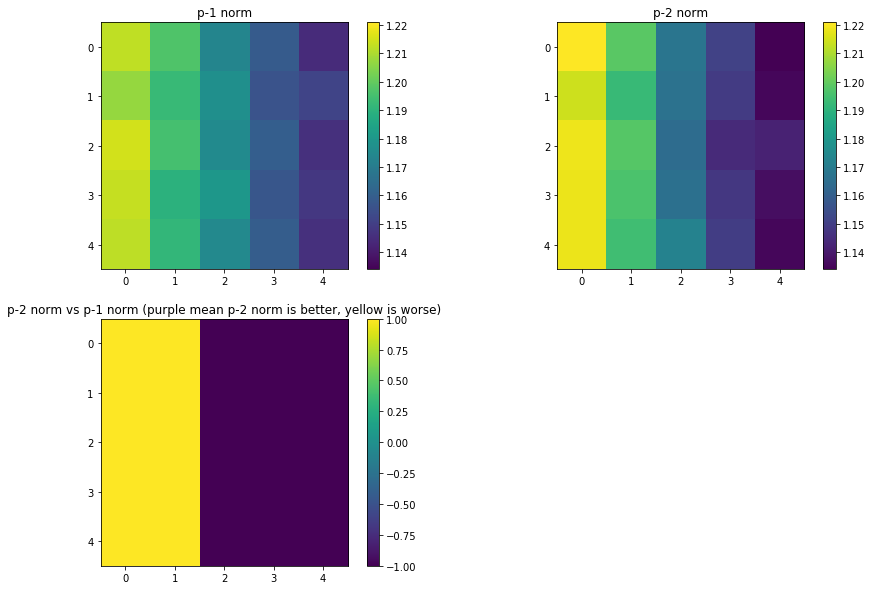

In [518]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(pt_matrix_1norm, vmin=np.min([pt_matrix_1norm, pt_matrix_2norm]), vmax=np.max([pt_matrix_1norm, pt_matrix_2norm]))
plt.colorbar()
plt.title('p-1 norm')
plt.subplot(222)
plt.imshow(pt_matrix_2norm, vmin=np.min([pt_matrix_1norm, pt_matrix_2norm]), vmax=np.max([pt_matrix_1norm, pt_matrix_2norm]))
plt.colorbar()
plt.title('p-2 norm')

better_worse = pt_matrix_2norm - pt_matrix_1norm
better_worse[better_worse < 0] = -1
better_worse[better_worse >= 0] = 1
plt.subplot(223)
plt.imshow(better_worse)
plt.colorbar()
plt.title('p-2 norm vs p-1 norm (purple mean p-2 norm is better, yellow is worse)')

### Question 18

Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?

**As we can see from the bottom left plot, it really depends on the threshold. For the two lowest threshold values, the p-1 norm yields better results, but for the three other values the p-2 norm is better. We can also see that we best overall score is obtained with the p-2 norm. It is hard to judge with only 5 values for each parameter if one method has a clear advantage over the over one.**